# Análise da clusterização das notícias

## Imports, definição de funções e carregamento dos dados

In [1]:
from b_limpar.limpador import Limpador
from b_vetorizar.vetorizador import Vetorizador
from c_clusterizar_por_texto.clusterizador_textual import ClusterizadorTextual
from c_clusterizar_por_texto.otimizador_clusterizacao_textual import OtimizadorClusterizacaoTextual
from _common import util
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

plt.rcParams['figure.figsize'] = [15, 5]

noticias_df = util.carregar_todas_as_noticias() 
Limpador().limpar_se_necessario(noticias_df)
vetorizador = Vetorizador()
clusterizador = ClusterizadorTextual()
otimizador = OtimizadorClusterizacaoTextual(vetorizador, clusterizador, noticias_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Edson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Limpando titulo
Limpando resumo


## Impacto do epsilon sobre a clusterização

Como se pode observar no gráfico abaixo à esquerda, conforme aumenta o valor do hiperparâmetro epsilon, é incrementado o número de clusters, porém até certo ponto; a partir de um certo valor de epsilon, o número de clusters diminui. 

O gráfico direita mostra que, enquanto o número de outliers diminui, aumenta o número de itens agrupados num supercluster. Isso reflete o que ocorre no gráfico da esquerda: quando o epsilon passa do valor que produz o maior número de clusters, esse supercluster começa a "engolir" um grande número de itens até predominar.

O código da primeira célula abaixo executa a clusterização para uma faixa de valores de epsilon. Para o teste, foi utilizado o modelo Word2vec sem inclusão do resumo. O código da segunda célula abaixo gera os gráfico que relacionam o epsilon ao número de clusters, ao número de outliers e ao número de itens agrupados no maior cluster. 

In [10]:
vetorizador.vetorizar_word2vec(noticias_df, usar_texto_limpo=True, incluir_resumo=False)
num_classes = {}
num_outliers = {}
num_itens_na_maior_classe = {}
for eps in np.arange(0.01, 2.00, 0.01):
    clusterizador.clusterizar(noticias_df, epsilon = eps, min_samples=2)
    counter = Counter(noticias_df['assunto'])
    num_classes.update({eps: len(counter.items())})
    num_outliers.update({eps: counter.get(-1)})
    num_itens_na_maior_classe.update({eps: max({k: v for k, v in counter.items() if k != None and k > -1}.values())})

Vetorizando com Word2Vec


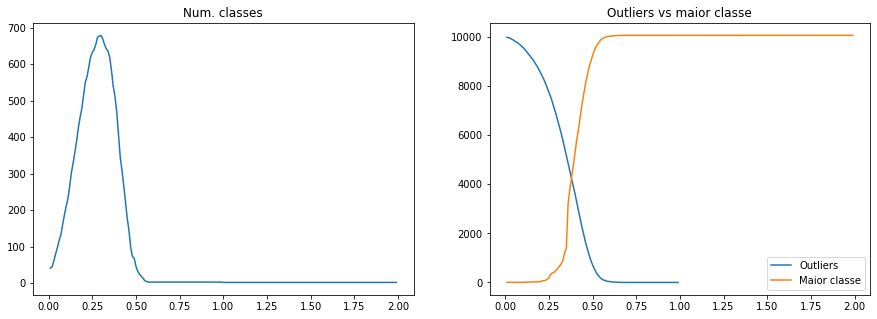

In [33]:
figure, axis = plt.subplots(1, 2)
axis[0].plot(list(num_classes.keys()), list(num_classes.values()))
axis[0].set_title("Num. clusters")
axis[1].plot(list(num_outliers.keys()), list(num_outliers.values()), label="Outliers")
axis[1].plot(list(num_itens_na_maior_classe.keys()), list(num_itens_na_maior_classe.values()), label="Maior cluster")
axis[1].set_title("Num. outliers vs num. itens no maior cluster")
axis[1].legend(loc="lower right")
plt.show()

## Busca pelos melhores hiperparâmetros

A célula abaixo faz uma busca bayesiana pelos cruzamentos de cenários e valores de hiperparâmetros possíveis: 
- Usar texto limpo: True, False
- Incluir o resumo ao vetorizar: True, False
- Modelo de linguagem: USE, SBERT, WORD2VEC
- Hiperparâmetro epsilon: escala de 0.01 a 2.00
- Hiperparâmetro min_samples: escala de 2 a 5

Considerando que se deseja agrupar itens que sejam realmente similares e levando em conta o comportamento do número de clusters exibido no gráfico acima, decidiu-se priorizar a combinação de valores que resulte no maior número de clusters.

In [2]:
resultado = otimizador.executar()

Baixando e carregando modelo Google USE
Vetorizando com Google USE
100%|██████████| 100/100 [05:20<00:00,  3.21s/trial, best loss: -372.0]
Vetorizando com Google USE
100%|██████████| 100/100 [05:12<00:00,  3.12s/trial, best loss: -419.0]
Vetorizando com Google USE
100%|██████████| 100/100 [05:42<00:00,  3.42s/trial, best loss: -255.0]
Vetorizando com Google USE
100%|██████████| 100/100 [05:39<00:00,  3.39s/trial, best loss: -420.0]
Baixando e carregando modelo SBERT
Vetorizando com SBERT
100%|██████████| 100/100 [05:17<00:00,  3.17s/trial, best loss: -679.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:17<00:00,  3.17s/trial, best loss: -856.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:11<00:00,  3.12s/trial, best loss: -645.0]
Vetorizando com SBERT
100%|██████████| 100/100 [05:02<00:00,  3.03s/trial, best loss: -904.0]
Baixando modelo Word2Vec
Carregando modelo Word2Vec
Vetorizando com Word2Vec
100%|██████████| 100/100 [03:41<00:00,  2.21s/trial, best loss: -469.0]
Veto

In [3]:
resultado

,modelo_linguagem,usar_texto_limpo,incluir_resumo,melhor_epsilon,melhor_min_samples,melhor_metric,maior_num_classes
0,USE,True,True,0.113163,2,cosine,372.0
1,USE,True,False,0.164393,2,cosine,419.0
2,USE,False,True,0.119678,2,cosine,255.0
3,USE,False,False,0.137167,2,cosine,420.0
4,SBERT,True,True,0.256549,2,cosine,679.0
5,SBERT,True,False,0.239138,2,cosine,856.0
6,SBERT,False,True,0.259471,2,cosine,645.0
7,SBERT,False,False,0.306722,2,cosine,904.0
8,WORD2VEC,True,True,0.111871,2,cosine,469.0
9,WORD2VEC,True,False,0.289800,2,cosine,677.0


## Visualização dos clusters

A célula abaixo salva no arquivo resultado_clusterizacao_textual.csv (e também exibe no output) os títulos das notícias e seus respectivos clusters. Os itens classificados como -1 são outliers. Os de classe vazia foram ignorados na clusterização por terem sido marcados como ignorados na etapa de limpeza. 

In [5]:
vetorizador.vetorizar_use(noticias_df, usar_texto_limpo=True, incluir_resumo=True)
ClusterizadorTextual().clusterizar(noticias_df, epsilon = 0.113163	, min_samples=4, metric='cosine')
noticias_clusterizadas_df = noticias_df[['assunto', 'titulo']].copy()
noticias_clusterizadas_df.sort_values('assunto', ascending=False, inplace=True)
noticias_clusterizadas_df.to_csv('resultado_clusterizacao_textual.csv', index=False)
noticias_clusterizadas_df

Vetorizando com Google USE


,assunto,titulo
10066,63,Mega-Sena sorteia nesta quarta-feira prêmio ac...
9261,63,Mega-Sena acumula e próximo prêmio é estimado ...
10610,63,Ninguém acerta a Mega-Sena e prêmio acumula em...
4687,63,Mega-Sena sorteia nesta quarta-feira prêmio es...
1299,62,Tipos de saques para liberação de FGTS
...,...,...
10669,None,Inflação leva britânicos aos bancos de alimentos
10651,None,Sine Maceió oferta mais de 200 vagas de empreg...
10650,None,Como falta de dinheiro prejudica inteligência ...
10646,None,"VÍDEOS: Gazeta Rural de domingo, 29 de maio"
